In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class HMM(nn.Module):
    def __init__(self, num_states, num_observations):
        super(HMM, self).__init__()
        self.num_states = num_states
        self.num_observations = num_observations
        # Transition matrix A (state to state)
        self.A = nn.Parameter(torch.randn(num_states, num_states))
        # Emission matrix B (state to observation)
        self.B = nn.Parameter(torch.randn(num_states, num_observations))
        # Initial state distribution π
        self.pi = nn.Parameter(torch.randn(num_states))

    def forward(self, observations):
        seq_len = len(observations)
        log_alpha = torch.zeros(seq_len, self.num_states)
        # Initial state probabilities
        log_alpha[0] = torch.log_softmax(self.pi, dim=0) + torch.log_softmax(self.B, dim=1)[:, observations[0]]
        # Forward pass
        for t in range(1, seq_len):
            for j in range(self.num_states):
                log_alpha[t, j] = torch.logsumexp(log_alpha[t-1] + torch.log_softmax(self.A, dim=1)[:, j], dim=0) + torch.log_softmax(self.B, dim=1)[j,observations[t]]
        return log_alpha
    
    def predict(self, observations):
        seq_len = len(observations)
        log_delta = torch.zeros(seq_len, self.num_states)
        psi = torch.zeros(seq_len, self.num_states, dtype=torch.long)
        # Initial state probabilities
        log_delta[0] = torch.log_softmax(self.pi, dim=0) + torch.log_softmax(self.B, dim=1)[:, observations[0]]
        # Viterbi pass
        for t in range(1, seq_len):
            for j in range(self.num_states):
                max_val, max_idx = torch.max(log_delta[t-1] + torch.log_softmax(self.A, dim=1)[:, j], dim=0)
                log_delta[t, j] = max_val + torch.log_softmax(self.B, dim=1)[j, observations[t]]
                psi[t, j] = max_idx
        # Backtrack
        states = torch.zeros(seq_len, dtype=torch.long)
        states[-1] = torch.argmax(log_delta[-1])
        for t in range(seq_len-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states

# Generate some synthetic data for demonstration
def generate_data(num_sequences, sequence_length, num_states, num_observations):
    A = np.random.rand(num_states, num_states)
    A = A / A.sum(axis=1, keepdims=True)
    B = np.random.rand(num_states, num_observations)
    B = B / B.sum(axis=1, keepdims=True)
    pi = np.random.rand(num_states)
    pi = pi / pi.sum()
    print(A,B,pi)
    
    sequences = []
    states = []
    
    for _ in range(num_sequences):
        seq = []
        state_seq = []
        state = np.random.choice(num_states, p=pi)
        for _ in range(sequence_length):
            obs = np.random.choice(num_observations, p=B[state])
            seq.append(obs)
            state_seq.append(state)
            state = np.random.choice(num_states, p=A[state])
        sequences.append(seq)
        states.append(state_seq)
    
    return sequences, states

# Parameters
num_states = 3
num_observations = 5
num_sequences = 100
sequence_length = 10

# Generate synthetic data
sequences, _ = generate_data(num_sequences, sequence_length, num_states, num_observations)

# Convert sequences to tensor
sequences = torch.tensor(sequences, dtype=torch.long)

# Initialize HMM model
model = HMM(num_states, num_observations)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    for sequence in sequences:
        optimizer.zero_grad()
        log_alpha = model(sequence)
        loss = -torch.logsumexp(log_alpha[-1], dim=0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/num_sequences}')

# Test the model with a new sequence
test_sequence = torch.tensor([0, 1, 2, 3, 4, 0, 1, 2, 3, 4], dtype=torch.long)
predicted_states = model.predict(test_sequence)
print("Predicted States:", predicted_states)


[[0.54731403 0.42694336 0.02574261]
 [0.37323558 0.19499239 0.43177204]
 [0.19273426 0.72463143 0.08263431]] [[2.97666407e-01 3.25956779e-01 4.84393065e-04 1.67585752e-01
  2.08306669e-01]
 [2.01534179e-01 2.11022232e-01 1.78684464e-01 2.46482666e-01
  1.62276460e-01]
 [1.13399826e-01 1.39256350e-01 9.07464921e-02 5.79611972e-01
  7.69853597e-02]] [0.2066849  0.56281579 0.23049931]
Epoch 1/100, Loss: 16.23250284194946
Epoch 2/100, Loss: 15.583347864151001
Epoch 3/100, Loss: 15.521059198379517
Epoch 4/100, Loss: 15.505535898208619
Epoch 5/100, Loss: 15.497172794342042
Epoch 6/100, Loss: 15.491176767349243
Epoch 7/100, Loss: 15.48656265258789
Epoch 8/100, Loss: 15.482920751571655
Epoch 9/100, Loss: 15.479993705749513
Epoch 10/100, Loss: 15.477599716186523
Epoch 11/100, Loss: 15.475605773925782
Epoch 12/100, Loss: 15.473912267684936
Epoch 13/100, Loss: 15.472446269989014
Epoch 14/100, Loss: 15.47115361213684
Epoch 15/100, Loss: 15.469995155334473
Epoch 16/100, Loss: 15.468944082260132
Epo

In [4]:
torch.softmax(model.A, dim=1),torch.softmax(model.B, dim=1),torch.softmax(model.pi, dim=0)

(tensor([[7.9661e-01, 1.0257e-01, 1.0082e-01],
         [4.8738e-01, 1.7493e-01, 3.3769e-01],
         [9.7432e-03, 9.9023e-01, 2.4559e-05]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.2921, 0.2832, 0.0907, 0.1546, 0.1793],
         [0.0515, 0.2198, 0.0236, 0.5912, 0.1139],
         [0.3339, 0.1655, 0.2219, 0.0737, 0.2050]], grad_fn=<SoftmaxBackward0>),
 tensor([0.2439, 0.3536, 0.4025], grad_fn=<SoftmaxBackward0>))

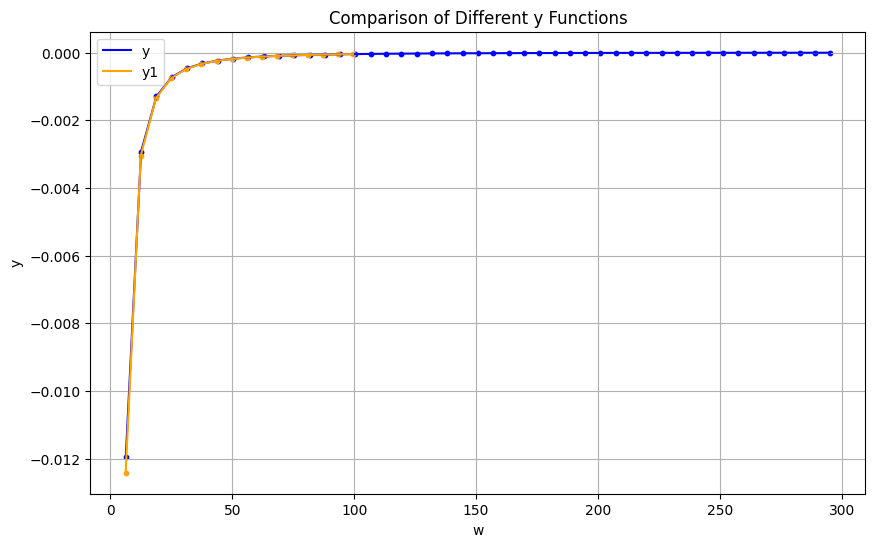

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# 生成数据
w = np.arange(2 * np.pi, 300, 2 * np.pi)
w = w[w != 1]
y = (-np.cos(w + 1) + 1) / (2 * (w + 1)) + (np.cos(w - 1) - 1) / (2 * (w - 1))

dw = 0.01
w1 = np.arange(2 * np.pi / (1 + dw), 100, 2 * np.pi / (1 + dw))
w1 = w1[w1 != 1]
y1 = (-np.cos((w1 + 1) * (1 + dw)) + 1) / (2 * (w1 + 1)) + (np.cos((w1 - 1) * (1 + dw)) - 1) / (2 * (w1 - 1))

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(w, y, label='y', color='blue')
plt.plot(w1, y1, label='y1', color='orange')

# 使用plt.scatter标注数据点
plt.scatter(w, y, color='blue', s=10)  # 标注第一个函数的点
plt.scatter(w1, y1, color='orange', s=10)  # 标注第二个函数的点

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Comparison of Different y Functions')
plt.xlabel('w')
plt.ylabel('y')

# 显示图表
plt.grid(True)
plt.show()

In [25]:
w,y

(array([  6.28318531,  12.56637061,  18.84955592,  25.13274123,
         31.41592654,  37.69911184,  43.98229715,  50.26548246,
         56.54866776,  62.83185307,  69.11503838,  75.39822369,
         81.68140899,  87.9645943 ,  94.24777961, 100.53096491,
        106.81415022, 113.09733553, 119.38052084, 125.66370614,
        131.94689145, 138.23007676, 144.51326207, 150.79644737,
        157.07963268, 163.36281799, 169.64600329, 175.9291886 ,
        182.21237391, 188.49555922, 194.77874452, 201.06192983,
        207.34511514, 213.62830044, 219.91148575, 226.19467106,
        232.47785637, 238.76104167, 245.04422698, 251.32741229,
        257.61059759, 263.8937829 , 270.17696821, 276.46015352,
        282.74333882, 289.02652413, 295.30970944]),
 array([-1.19468971e-02, -2.92962170e-03, -1.29746041e-03, -7.28921401e-04,
        -4.66243548e-04, -3.23679931e-04, -2.37761249e-04, -1.82013892e-04,
        -1.43801496e-04, -1.16472289e-04, -9.62538575e-05, -8.08772727e-05,
        -6.89113

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(1, 10)  # 输入层到隐藏层
        self.layer2 = nn.Linear(10, 20) # 隐藏层到隐藏层
        self.layer3 = nn.Linear(20, 20) # 隐藏层到隐藏层
        self.output_layer = nn.Linear(20, 1) # 隐藏层到输出层

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output_layer(x)
        return x
# 初始化模型
model = NeuralNetwork()
x_tensor = torch.tensor(w,dtype = torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y,dtype = torch.float32).unsqueeze(1)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(x_tensor):
    x_train, x_test = x_tensor[train_index], x_tensor[test_index]
    y_train, y_test = y_tensor[train_index], y_tensor[test_index]
    for epoch in range(1000):  # 训练1000个epoch
        model.train()
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
    # 测试模型
    model.eval()
    with torch.no_grad():
        test_output = model(x_test)
        test_loss = criterion(test_output, y_test)
    print(f'Fold Test Loss: {test_loss.item()}')

Fold Test Loss: 3.408193549603311e-07
Fold Test Loss: 1.0637284049153095e-06
Fold Test Loss: 1.4297233974502888e-05
Fold Test Loss: 4.195636620352161e-07
Fold Test Loss: 4.922856078337645e-07


In [34]:
x_tensor,y_tensor

(tensor([[  6.2832],
         [ 12.5664],
         [ 18.8496],
         [ 25.1327],
         [ 31.4159],
         [ 37.6991],
         [ 43.9823],
         [ 50.2655],
         [ 56.5487],
         [ 62.8319],
         [ 69.1150],
         [ 75.3982],
         [ 81.6814],
         [ 87.9646],
         [ 94.2478],
         [100.5310],
         [106.8141],
         [113.0973],
         [119.3805],
         [125.6637],
         [131.9469],
         [138.2301],
         [144.5133],
         [150.7964],
         [157.0796],
         [163.3628],
         [169.6460],
         [175.9292],
         [182.2124],
         [188.4956],
         [194.7787],
         [201.0619],
         [207.3451],
         [213.6283],
         [219.9115],
         [226.1947],
         [232.4779],
         [238.7610],
         [245.0442],
         [251.3274],
         [257.6106],
         [263.8938],
         [270.1770],
         [276.4601],
         [282.7433],
         [289.0265],
         [295.3097]]),
 tensor([[-

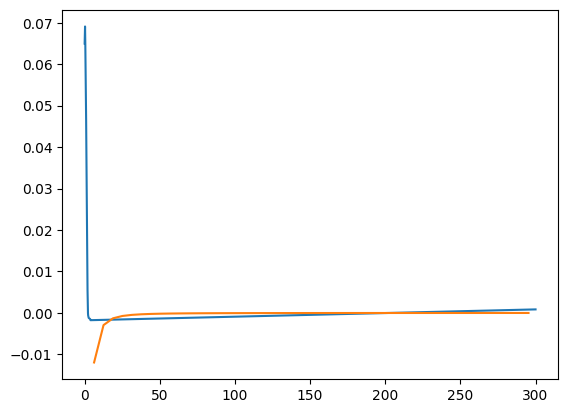

In [35]:
with torch.no_grad():
    test = torch.tensor(np.linspace(0,300,10000),dtype=torch.float32).unsqueeze(1)
    test_y = model(test)
    plt.plot(test,test_y)
    plt.plot(x_tensor,y_tensor)
    plt.show()

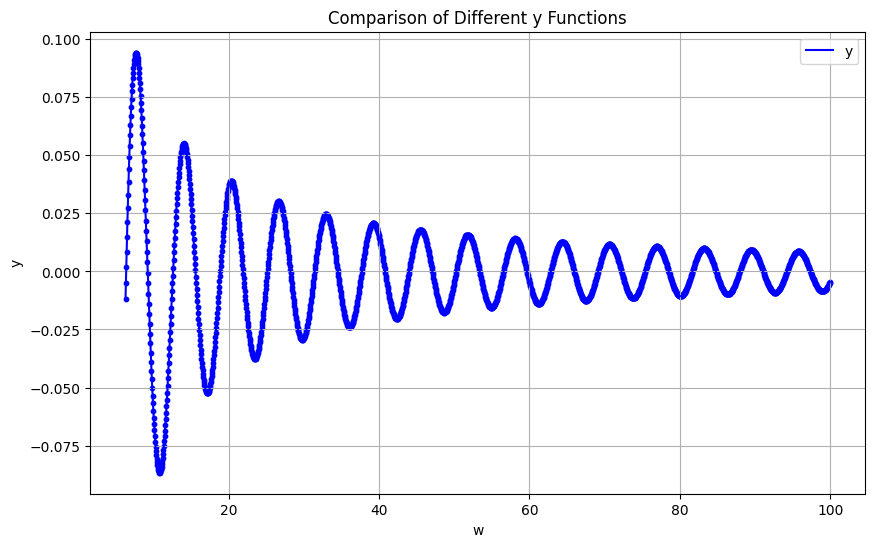

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 生成数据
w = np.arange(2 * np.pi, 100, 0.05)
w = w[w != 1]
y = (-np.cos(w + 1) + 1) / (2 * (w + 1)) + (np.cos(w - 1) - 1) / (2 * (w - 1))

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(w, y, label='y', color='blue')

# 使用plt.scatter标注数据点
plt.scatter(w, y, color='blue', s=10)  # 标注第一个函数的点

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Comparison of Different y Functions')
plt.xlabel('w')
plt.ylabel('y')

# 显示图表
plt.grid(True)
plt.show()

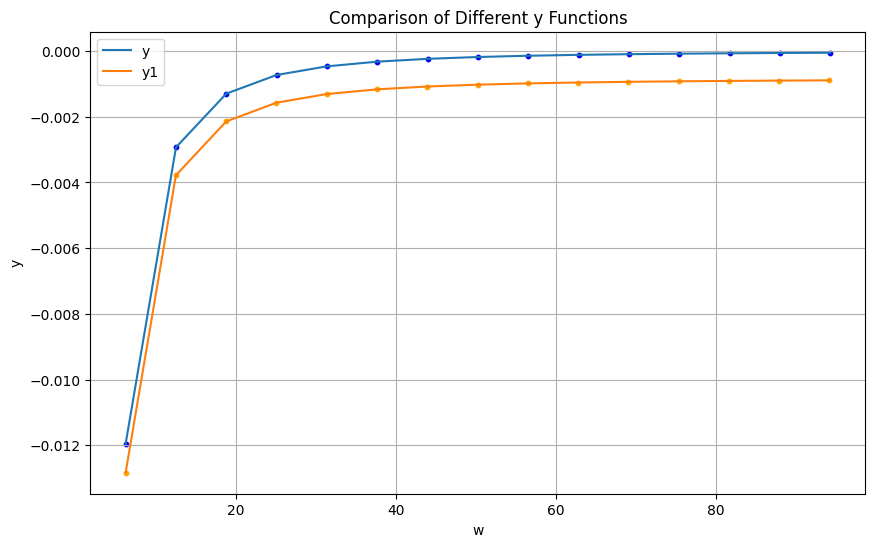

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 生成数据
w = np.arange(2 * np.pi, 100, 2 * np.pi)
w = w[w != 1]
y = (-np.cos(w + 1) + 1) / (2 * (w + 1)) + (np.cos(w - 1) - 1) / (2 * (w - 1))

dw = 0.001
w1 = np.arange(2 * np.pi / (1 + dw), 100, 2 * np.pi / (1 + dw))
w1 = w1[w1 != 1]
y1 = (-np.cos(w1 + 1) + 1) / (2 * (w1 + 1)) + (np.cos(w1 - 1) - 1) / (2 * (w1 - 1))

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(w, y, label='y')
plt.plot(w1, y1, label='y1')

# 使用plt.scatter标注数据点
plt.scatter(w, y, color='blue', s=10)  # 标注第一个函数的点
plt.scatter(w1, y1, color='orange', s=10)  # 标注第二个函数的点

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Comparison of Different y Functions')
plt.xlabel('w')
plt.ylabel('y')

# 显示图表
plt.grid(True)
plt.show()

In [6]:
w2,y2

(array([ 1.57079633,  3.14159265,  4.71238898,  6.28318531,  7.85398163,
         9.42477796, 10.99557429, 12.56637061, 14.13716694, 15.70796327,
        17.27875959, 18.84955592, 20.42035225, 21.99114858, 23.5619449 ,
        25.13274123, 26.70353756, 28.27433388, 29.84513021, 31.41592654,
        32.98672286, 34.55751919, 36.12831552, 37.69911184, 39.26990817,
        40.8407045 , 42.41150082, 43.98229715, 45.55309348, 47.1238898 ,
        48.69468613, 50.26548246, 51.83627878, 53.40707511, 54.97787144,
        56.54866776, 58.11946409, 59.69026042, 61.26105675, 62.83185307,
        64.4026494 , 65.97344573, 67.54424205, 69.11503838, 70.68583471,
        72.25663103, 73.82742736, 75.39822369, 76.96902001, 78.53981634,
        80.11061267, 81.68140899, 83.25220532, 84.82300165, 86.39379797,
        87.9645943 , 89.53539063, 91.10618695, 92.67698328, 94.24777961,
        95.81857593, 97.38937226, 98.96016859]),
 array([-1.12691998e+00, -1.86439389e-01, -7.79777451e-02, -4.29758738e-02,

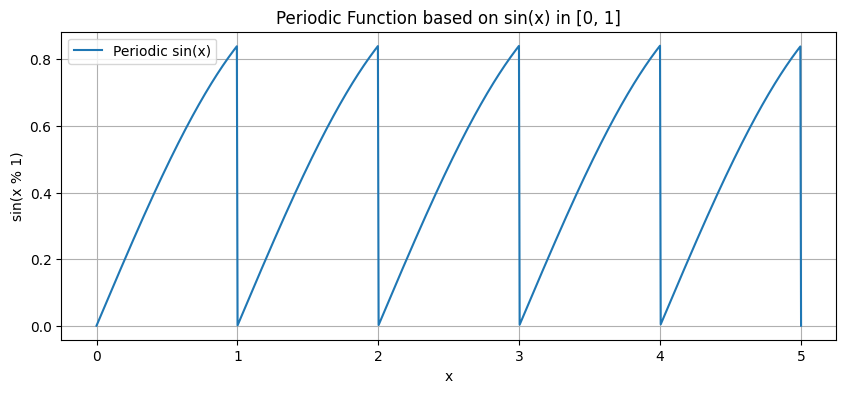

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 自定义周期函数
def periodic_sin(x):
    return np.sin((x % 1))

# 生成数据
x = np.linspace(0, 5, 1000)  # 从0到5，生成1000个点
y = periodic_sin(x)

# 绘制图像
plt.figure(figsize=(10, 4))
plt.plot(x, y, label='Periodic sin(x)')
plt.xlabel('x')
plt.ylabel('sin(x % 1)')
plt.title('Periodic Function based on sin(x) in [0, 1]')
plt.legend()
plt.grid(True)
plt.show()

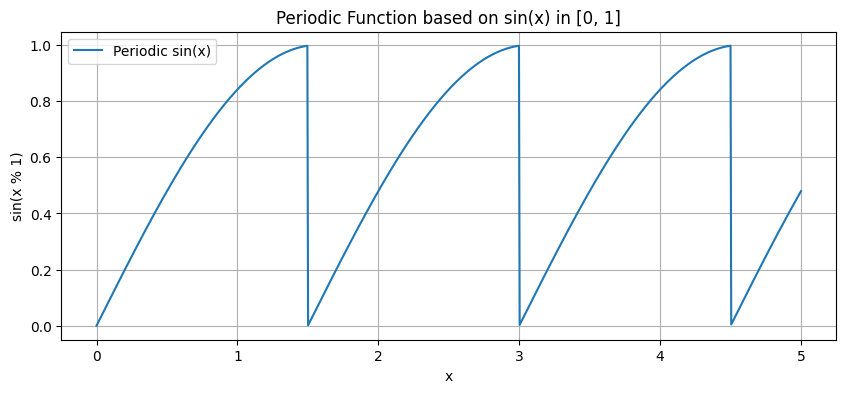

In [11]:
import numpy as np
import matplotlib.pyplot as plt
# 自定义周期函数
def periodic_sin(x,widow):
    return np.sin((x % widow))
# 生成数据
x = np.linspace(0, 5, 1000)  # 从0到5，生成1000个点
y = periodic_sin(x,1.5)
# 绘制图像
plt.figure(figsize=(10, 4))
plt.plot(x, y, label='Periodic sin(x)')
plt.xlabel('x')
plt.ylabel('sin(x % 1)')
plt.title('Periodic Function based on sin(x) in [0, 1]')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
w=1.57
y = (-np.cos(w+1)+1)/(2*(w+1)) + (np.cos(w-1)-1)/(2*(w-1))
y

0.21949572286482538

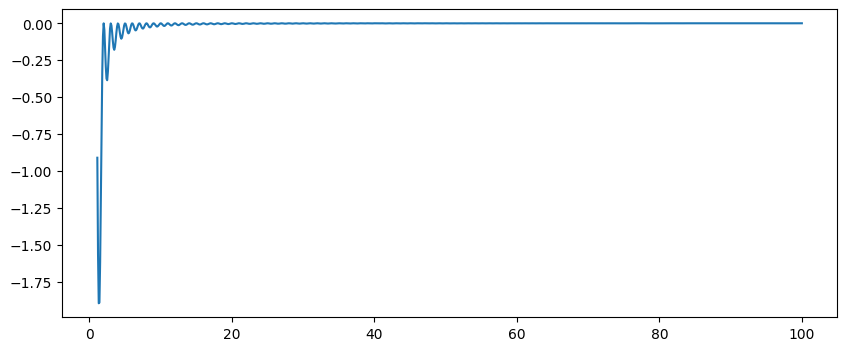

In [2]:
import numpy as np
#w = np.linspace(1.1,100,1000)
#y = (-np.cos((w+1)*2*np.pi)+1)/(2*(w+1)) + (np.cos((w-1)*2*np.pi)-1)/(2*(w-1))
#import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(w,y3)
plt.show()

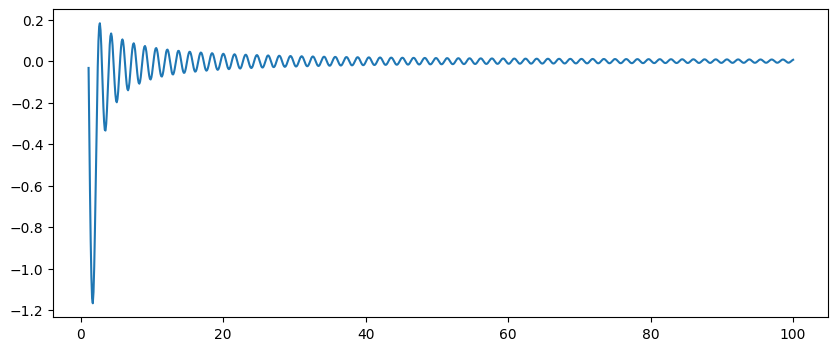

In [3]:
import numpy as np
#w = np.linspace(1.1,100,1000)
#y = (-np.cos((w+1)*2*np.pi)+1)/(2*(w+1)) + (np.cos((w-1)*2*np.pi)-1)/(2*(w-1))
#import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(w,y2)
plt.show()

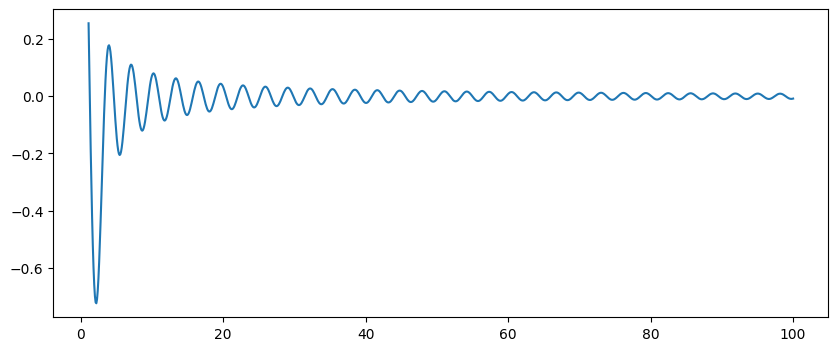

In [4]:
import numpy as np
#w = np.linspace(1.1,100,1000)
#y = (-np.cos((w+1)*2*np.pi)+1)/(2*(w+1)) + (np.cos((w-1)*2*np.pi)-1)/(2*(w-1))
#import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(w,y1)
plt.show()

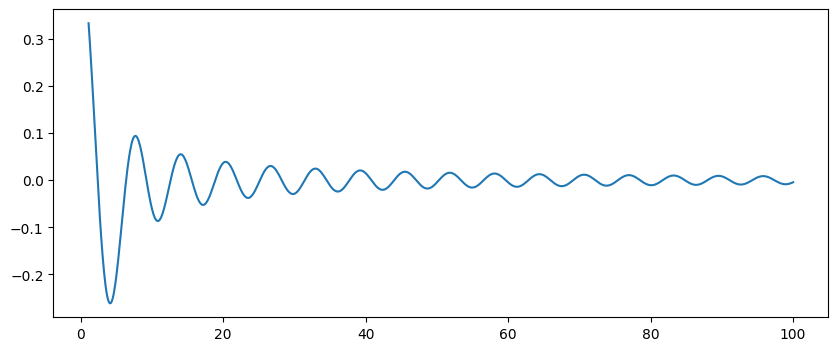

In [5]:
import numpy as np
#w = np.linspace(1.1,100,1000)
#y = (-np.cos((w+1)*2*np.pi)+1)/(2*(w+1)) + (np.cos((w-1)*2*np.pi)-1)/(2*(w-1))
#import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(w,y)
plt.show()

In [8]:
w = 2.5
y = (-np.cos((w+1)*2*np.pi)+1)/(2*(w+1)) + (np.cos((w-1)*2*np.pi)-1)/(2*(w-1))
y

-0.38095238095238093

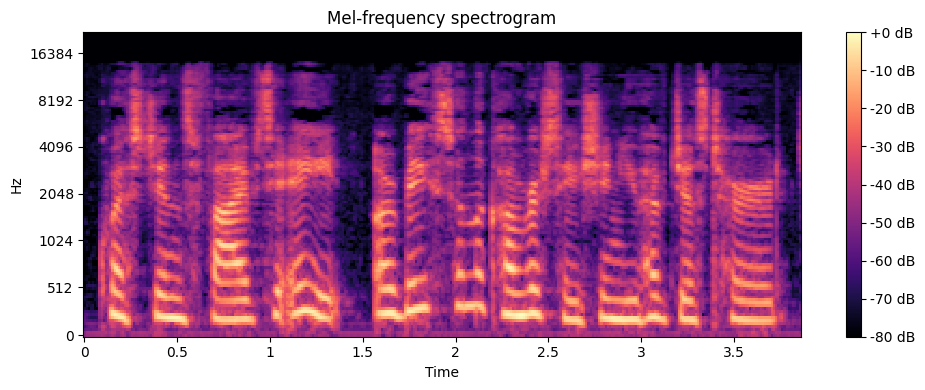

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# 加载音频文件
audio_path = '../tts/examples/default.wav'
y, sr = librosa.load(audio_path, sr=None)

# 计算梅尔谱
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# 转换为对数刻度
S_dB = librosa.power_to_db(S, ref=np.max)

# 显示梅尔谱图
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()